# A naive comparison of data query performance between kdb+/q and GPU

## 1. Introduction

'Select-By' is a basic database query commonly used on tables to get the last value by a certain column name(s) as known as the key column. kdb+/q is well-known for its strong performance on columnar tables and fast speed on grouping data by key column(s). Especially with the nature of in-memory processing, it can leverage the high speed RAM and high CPU clock freuqencies to achieve results in lightening speed.

GPU is the top popular hardware that is being discussed all over the world, mostly famous for its supreme power on AI performance. Nvidia's CUDA technology specifically excels in this domain due to its extremem parallel processing capabilities built on thousands of GPU cores (CUDA). It also provides significant advantage on parallelizing database queries such as grouping and aggregation.

In this notebook, we will be exploring the performances of CPU bound 'select-by' performance, and the GPU bound performance, using a consumer grade hardware, to have an idea of how fast each of them are processing.

**\*All code in this notebook are in python**

## 2. Proof of Concept
We want to use a quick demo to verify that the test plan is workable.

1. Prepare a small table in kx.q to run 'select by' query
2. Run kx.q(query) to get the result on q process and bring the result back to python and store as pandas dataframe
3. Run cudf to get the result on gpu and bring back to python and store as pandas dataframe
4. Use pandas comparison features to verify the results

In [1]:
import pykx as kx
import pandas as pd
import numpy as np
import cudf
import cupy
import matplotlib.pyplot as plt

Notice that in pykx, the embedded q session automatically utilizes all the 24 CPU threads without explicitly setting \s

This helps us confirm that the CPU is fully utilized to increase performance.

In [2]:
kx.q('\s')

pykx.IntAtom(pykx.q('24i'))

#### 2.1 Quick Example for POC

In [3]:
# generate a table of 10000 rows with 2 columns of random int
qsql=f'x:10000;d:([]id:x?x;nid:x?x)'
# the table will reside in the embedded q process after running the q sql
kx.q(qsql)
# run 'select-by' on table d and save result in r
qresult = kx.q("0!select by nid from d").pd().reset_index(drop=True)
print(f'q result is : {qresult}')

# using pykx function pd() to convert q process data to pandas data frame, and then pass into gpu using cudf from_pandas()
gpudf = cudf.DataFrame.from_pandas(kx.q('d').pd())
# run cudf functions to achieve equivalent 'select by' result ( note that kdb+ sorts the key column when running select-by, therefore the gpu result also needs to be sorted )
gresult = gpudf.groupby('nid').last().reset_index().sort_values('nid').to_pandas()
print(f'gpu result is {qresult}')

q result is :        nid    id
0        0  8719
1        2  6863
2        6   267
3        7  2810
4        8  5503
...    ...   ...
6311  9992  7755
6312  9993  4796
6313  9994  4579
6314  9995  4823
6315  9996  8594

[6316 rows x 2 columns]
gpu result is        nid    id
0        0  8719
1        2  6863
2        6   267
3        7  2810
4        8  5503
...    ...   ...
6311  9992  7755
6312  9993  4796
6313  9994  4579
6314  9995  4823
6315  9996  8594

[6316 rows x 2 columns]


First look of the two results are the same. We can define a comparison function to verify that the results match.

#### 2.2 Verification of results

In [16]:
def result_equal(qresult, gresult):    
    print("Index equal:", qresult.index.equals(gresult.index))
    print("Columns equal:", qresult.columns.equals(gresult.columns))
    print("Columns type equal:", qresult.dtypes == gresult.dtypes)
    print("Element-wise equality:\n", (qresult == gresult).all().all())  # True if all values match        
    print("Array equal:", np.array_equal(qresult.to_numpy(), gresult.to_numpy()))
    return qresult.shape == gresult.shape and qresult.columns.equals(gresult.columns) and qresult.index.equals(gresult.index) and np.array_equal(qresult.to_numpy(), gresult.to_numpy())

In [17]:
result_equal(qresult, gresult)

Index equal: True
Columns equal: True
Columns type equal: nid    True
id     True
dtype: bool
Element-wise equality:
 True
Array equal: True


True

We can see that both the values in the results match, the metadata also match.
Now we have verified that the two methods can produce the same results, we can move on to the benchmarking stage

## 3. Define benchmark steps and specifications
- init q workspace
- generate data based on row count N (0 - 100M )
- run "select by" statement inside the embedded q process and collect time cost
- run GPU cudf equivalent on the GPU side and collect time cost ( this will include the data transfer overhead from RAM to GPU and GPU to RAM )
- carry out 3 runs for every data size, take average time cost to avoid bias

Note that the benchmarking of GPU time cost is a naive implementation based on CuPy reference:
https://docs.cupy.dev/en/stable/user_guide/performance.html

More sophisticated profiling methods can be used to provide better insights.

#### 3.1 Define benchmark functions

In [6]:
def benchmark_q():
    qts = kx.q('system"t r:0!select by nid from d"').py()       # store time cost in python object
    qre = kx.q('r').pd().reset_index(drop=True)                 # store result in pandas dataframe
    return qts, qre

def benchmark_gpu():
    start = cupy.cuda.Event()                                   # use cupy to capture time cost
    end = cupy.cuda.Event()
    start.record()    
    gdf = cudf.DataFrame.from_pandas(kx.q('d').pd())            # convert q table object to pandas dataframe, and then transfer to gpu dataframe    
    result = gdf.groupby('nid').last().reset_index().sort_values('nid').to_pandas()  # run cuda dataframe logic and transfer the result back to pandas dataframe, i.e. back to CPU/RAM
    end.record()
    end.synchronize()
    elapsed_ms = cupy.cuda.get_elapsed_time(start, end)         # note that the overhead of data transfer cost from CPU -> GPU and GPU -> CPU are included
    return elapsed_ms, result

def benchmark(n:int):
    kx.q('delete d,r from `.;.Q.gc[]')         # init q workspace to cleanup heap memory
    qsql=f'x:{n};d:([]id:x?x;nid:x?x)'         # generate data based on row count N    
    kx.q(qsql)                                 # run q sql
    qts,qre = benchmark_q()                    # collect q benchmark results
    gts,gre = benchmark_gpu()                  # collect gpu benchmark results    
    rv = result_equal(qre, gre)
    print(f'Data Comparison between q result and GPU result : {rv}')   # print result comparison matching
    return qts, gts, rv


#### 3.2 Run benchmarks
We use two caches to store the time cost for q and GPU separately, one cache for data comparison boolean result.

The test data size range is from 0 to 100M, with step of 1M

Time cost and result comparison results are printed in each round.

In [ ]:
# initialize result cache for both methods
keys = ['cnt','ts']
qdict = {key: [] for key in keys}   # q result cache
gdict = {key: [] for key in keys}   # gpu result cache
result_validation = []              # result validation cache

test_n = [i for i in range(0, 101_000_000, 1000000)]         # from 0 rows to 100M rows, with step of 1MM
for n in test_n:
    qt1, gt1, rv1 = benchmark(n)                             # collect 3 runs for every data size, take average to avoid outliers
    qt2, gt2, rv2 = benchmark(n)
    qt3, gt3, rv3 = benchmark(n)
    qts = np.mean([qt1, qt2, qt3])                           # get average time cost
    gts = np.mean([gt1, gt2, gt3])
    rv = all((rv1, rv2, rv3))                                # confirm all 3 results match
    print(f"time cost is \t | q: {qts} ms and GPU : {gts} ms for row count {n}")
    qdict['cnt'].append(n)    
    qdict['ts'].append(qts)
    gdict['ts'].append(gts)
    result_validation.append(rv)

Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
time cost is 	 | q: 0.0 ms and GPU : 1.6716372966766357 ms for row count 0
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
time cost is 	 | q: 24.0 ms and GPU : 14.983370463053385 ms for row count 1000000
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
time cost is 	 | q: 64.66666666666667 ms and GPU : 29.113375981648762 ms for row count 2000000
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
Data Comparison between q result and GPU result : True
time cost is 	 | q: 104.0 ms and GPU : 44.54094950358073 ms for row count 3000000
Data C

#### 3.3 Verify that all results match

All results generated in every benchmark round should match

In [10]:
print(f'All results for all data sizes match : {all(result_validation)}')

All results for all data sizes match : True


## 4. Hardware/System Statistics for 100M Rows during benchmark

#### 4.1 Run one benchmark on 100M rows

In [ ]:
# run benchmark
benchmark(100000000)

Data Comparison between q result and GPU result : True


(6073, 1220.092529296875, True)

#### 4.2 Retrieve q heap info

In [ ]:
# retrieve q session memory info
kx.q('.Q.w[]%1e9')

,
,
used,3.223299
heap,7.583302
peak,7.583302
wmax,0f
mmap,0f
mphy,33.56764
syms,3.496e-06
symw,0.000181422


#### 4.3 General system properties during benchmark
The system's statistics are as following:

RAM usage      :  16GB

GPU VRAM usage :  2.5GB

q mem usage    :  3.2GB

q heap size    :  7.6GB

## 5. Illustration of performance of q process on CPU, and GPU CUDA
The results of time cost of the queries are plotted using matplotlib as below.

#### 5.1 Time vs Size
x-axis shows the table size in millions (MM)

y-axis shows the 'select-by' query time in ms

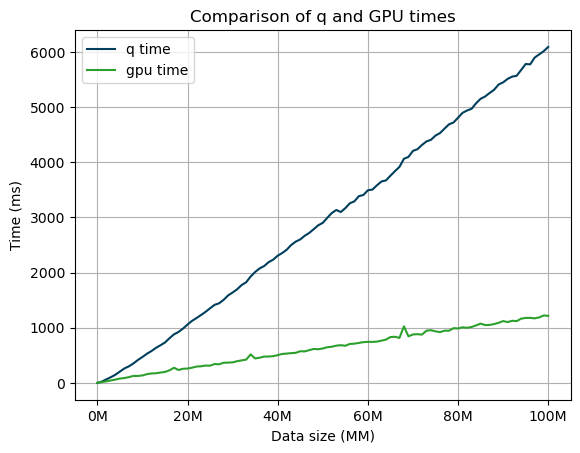

In [11]:
from matplotlib.ticker import FuncFormatter

# Plot
plt.plot(qdict['cnt'], qdict['ts'], label='q time', color='#003f5c')
plt.plot(qdict['cnt'], gdict['ts'], label='gpu time', color='#2ca02c')

# Format x-axis to show in K
formatter = FuncFormatter(lambda x_val, _: f'{x_val/1000000:.0f}M')
plt.gca().xaxis.set_major_formatter(formatter)

# Labels and title
plt.xlabel('Data size (MM)')  # or any label for x
plt.ylabel('Time (ms)')
plt.title('Comparison of q and GPU times')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### 5.2 Relative performance by size

We also draw a bar chart showing the time performance comparison in percentage (%) at each millions of rows

x-axis shows the number of rows in millions (MM)

y-axis shows the 'select-by' query time in ms

% number on the green bar shows the relative time cost comparing to the q process (blue bar)

10


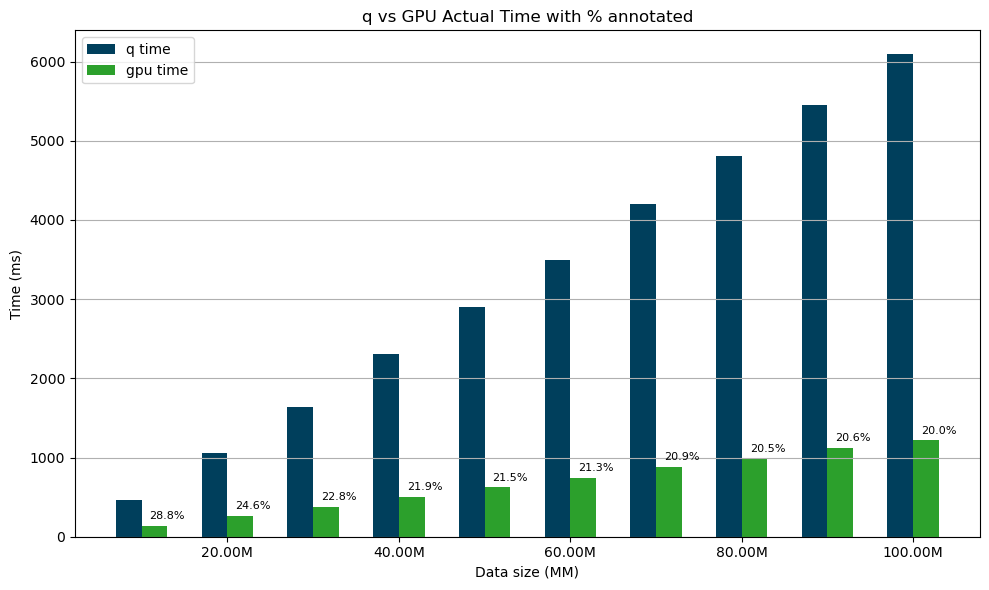

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

x = qdict['cnt']

# === CONFIG ===
offset = 1_0000_000
threshold_step = 1_0000_000
max_x_val = max(x)
target_xs = list(range(offset, max_x_val + 1, threshold_step))
print(len(target_xs))
# Map x to index
x_index_map = {val: idx for idx, val in enumerate(x)}

# Gather data
bar_x = []
q_vals = []
g_vals = []
pct_labels = []

for tx in target_xs:
    if tx in x_index_map:
        i = x_index_map[tx]
        qt = qdict['ts'][i]
        gt = gdict['ts'][i]
        if qt > 0:
            bar_x.append(tx)
            q_vals.append(qt)
            g_vals.append(gt)
            pct = 100 * gt / qt
            pct_labels.append(f'{pct:.1f}%')
        else:
            # If qt == 0, avoid division by zero
            bar_x.append(tx)
            q_vals.append(qt)
            g_vals.append(gt)
            pct_labels.append('N/A')

# Plotting
bar_width = threshold_step * 0.3
x_vals = np.array(bar_x)

fig, ax = plt.subplots(figsize=(10, 6))

bars_q = ax.bar(x_vals - bar_width/2, q_vals, width=bar_width, label='q time', color='#003f5c')  # deep blue
bars_g = ax.bar(x_vals + bar_width/2, g_vals, width=bar_width, label='gpu time', color='#2ca02c')  # vibrant green

# Format x-axis to show in millions
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{(x - offset + threshold_step) / 1_000_000:.2f}M'))

# Add % labels on top of gdict bars
for bar, label in zip(bars_g, pct_labels):
    ax.text(bar.get_x() + bar.get_width() * 1, bar.get_height() + max(q_vals) * 0.01,
            label, ha='center', va='bottom', fontsize=8, rotation=0, color='black')

# Labels and layout
ax.set_xlabel('Data size (MM)')
ax.set_ylabel('Time (ms)')
ax.set_title('q vs GPU Actual Time with % annotated')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()


## 6. Analysis

The results and charts show that even with data transfer overhead through the pipeline ( pykx.q() -> CPU pandas dataframe -> GPU cuda dataframe -> CPU pandas dataframe ), GPU can deliever over **5x** the performance as CPU due to the overwhelming advantage of number of cores when it comes to parallelized data processing.

Both the CPU and GPU performances have linear relationship with the data size while GPU performance is affected by a much smaller factor.

100M rows of data seems to be using reasonable memory either in RAM or GPU, however, there's a large overhead between real data size and the heap that python requires during object conversion between the q session and pandas/cuda. At 100M rows, the real q data size is 3GB but python requires 16GB of RAM to hold the data in pandas, which suggest an inefficiency of interation between q and python.

#### 6.1 Conclusion
While memory size is within the limit, it might be worth while to consider leveraging GPU to speed up certain data queries that are relatively slow in q with the help of pykx's API to convert objects between q and python.

#### 6.2 Limitations and Improvements

#### 6.2.1 Limiation of memory usage 
The PC system used in this test has 32GB of RAM limitations and 16GB of GPU VRAM limitations which blocks us from testing higher volumne of data no more than 150M rows so that we are not able to simulate the situation where GPU VRAM is not enough to process the data while CPU RAM can, which can be a key decision factor for certain usages with large data.

Large data volumes might also demonstrate higher overhead of data transfer cost between CPU and GPU which decreases GPU performance.

Modern GPU's VRAM capacity is much lower than RAM capacity even in the enterprise domain, and at much higher cost, this leads to trade-offs when choosing between the solutions.

#### 6.2.2 Complexity of query
'select-by' is a basic query in real world usecases. kdb+/q supports queries with much higher complexity, whether those can be achieved using python/CUDA dataframe are yet to be learned and tested

#### 6.2.3 Higher end CPU and GPU to be tested
There might be a hardware discrepancy between the CPU performance and GPU in this test. Higher end CPUs might deliever comparable results.

## 7. Appendix Material

#### To avoid kdb+/q performance bias between pykx's embedded q session and the native q session from l64/q binary, we did a comparison between the two using data size of 100M

We started a native q session in linux terminal with '-s 24' to be consistent with the test configuration.

'select-by' was run on a table with 100M rows and time-space complexity are matching the benchmark result at the same data size.

In [ ]:
KDB+ 4.1 2025.02.18 Copyright (C) 1993-2025 Kx Systems
l64/ 24(24)core 32012MB hyin hyin-desktop 127.0.1.1 EXPIRE 2026.03.25 yxcntu@gmail.com KDB PLUS PERSONAL #5025134
q)x:100000000;d:([]id:x?x;nid:x?x)
q)\ts select by nid from d
6089 3221226288     / time cost 6000ms is similar to benchmark
q)\s                / confirm threads count
24i
q)3221226288%1e9    / convert mem usage to GB
3.221226
q)


## Reference
1. https://code.kx.com/pykx/3.1/index.html
2. https://docs.cupy.dev/en/stable/user_guide/performance.html
3. https://github.com/rapidsai/cudf
4. https://www.techpowerup.com/cpu-specs/ryzen-9-5900x.c2363
5. https://www.techpowerup.com/gpu-specs/geforce-rtx-4060-ti-16-gb.c4155
6. https://en.wikipedia.org/wiki/CUDA
